In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path, walk, listdir
from os.path import isfile
from statistics import fmean
import re
from tqdm import tqdm
import pyarrow

# Constants

In [140]:
RUNTIME_SECONDS = 3600

DIR_Classic = "../bench_data/classic/"
DIR_Modified = "../bench_data/modified/"

REGEX_NODES = r"\d+_nodes"
REGEX_VERSION = r"(modified)|(classic)"
REGEX_DURATION = r"\d+_minutes"
REGEX_RUN = r"run_\d+"
REGEX_PROBABILITY = r"(even)|(biased)"

COLOR_PALETTE = ['#0072B2', '#E1812C', "#009E73", "#CC79A7", "#56B4E9", "#8FF7A7", "#F0E442"]

# Utility Functions

In [141]:
def find_all_csvs(rootpath : str) -> list[str]:
    csvs = []
    for root, dirs, files in walk(rootpath):
        for dir in dirs:
            dir_path = path.join(root, dir)
            csvs = csvs + [path.normpath(path.abspath(path.join(root, dir, file))) for file in listdir(dir_path) if file.endswith('csv')]
    return csvs

def find_all_csvs_and_join(rootpaths : list[str]) -> list[str]:
    csvs = []
    for path in rootpaths:
        csvs = csvs + find_all_csvs(path)
    return csvs

In [142]:
FILES = find_all_csvs("..\\bench_data")

In [143]:
def open_csv(path : str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[df.leaderId != -1] # Remove the initial dummy entries
    return df

In [144]:
def find_node_count(df : pd.DataFrame) -> int:
    return len(df["serverId"].unique())

In [145]:
def find_quorum_size(df : pd.DataFrame) -> int:
    return find_node_count(df) // 2 + 1

In [146]:
def get_node_count(file : str) -> int:
    num, _ = re.search(REGEX_NODES, file).group().split("_", maxsplit=1)
    return int(num)

def get_duration_minutes(file : str) -> int:
    num, _ = re.search(REGEX_DURATION, file).group().split("_", maxsplit=1)
    return int(num)

def get_algorithm_type(file : str) -> str:
    return re.search(REGEX_VERSION, file).group()

def get_run_id(file : str) -> str:
    return re.search(REGEX_RUN, file).group()

def get_probability_type(file : str) -> str:
    return re.search(REGEX_PROBABILITY, file).group()

# Work per Leader

## Committed entries

In [147]:
def plot_leader_commit_counts(df : pd.DataFrame, title=None):
    leaders = df["leaderId"].value_counts()
    leaders = leaders / len(df)
    # plt.bar(leaders.index, leaders)
    sns.barplot(leaders)
    plt.ylim(0,1)
    if not title is None:
        plt.title(title)
    plt.show()

In [148]:
for file in find_all_csvs("../bench_data/"):
    algo = get_algorithm_type(file)
    nodes = get_node_count(file)
    minutes = get_duration_minutes(file)
    run = get_run_id(file)
    crash_probability = get_probability_type(file)
    # plot_leader_commit_counts(open_csv(file), f"{algo} {run}: {nodes} nodes for {minutes} min (p = {crash_probability})")

# Performance

## Entry Throughput

In [149]:
def find_replicated_count(df : pd.DataFrame, node_count : int) -> int:
    entry_counts = df.groupby('serverId').size()
    committed = []
    for count in entry_counts:
        replicated_count = sum(map(lambda x: x >= count, entry_counts))
        if replicated_count >= node_count:
            committed.append(count)
    return max(committed) if len(committed) > 0 else 0

def find_committed_count(df : pd.DataFrame) -> int:
    return find_replicated_count(df, find_quorum_size(df))

def find_fully_replicated_count(df : pd.DataFrame) -> int:
    return find_replicated_count(df, find_node_count(df))

In [150]:
def split_logs_by(df : pd.DataFrame, column : str) -> pd.DataFrame:
    logs : list[pd.DataFrame] = []
    for val in df[column].unique():
        logs.append(df[df[column] == val])
    return logs


In [151]:
def find_replication_delays(df : pd.DataFrame, num_nodes : int):
    logs = split_logs_by(df, "serverId")

    last_replicated = find_replicated_count(df, num_nodes)
    
    delays = []

    for i in range(last_replicated):
        creation_time = min([log.iloc[i]["creationTime"] for log in logs if len(log) > i])
        storage_times = [log.iloc[i]["storageTime"] for log in logs if len(log) > i]
        
        if len(storage_times) < num_nodes:
            delays.append(None)
            print(f"None at {i}. Need {num_nodes}, have {len(storage_times)}")
        else:
            storage_times.sort()
            delays.append(storage_times[num_nodes - 1] - creation_time)
    return delays
        

In [152]:
def process_data(paths : list[str]) -> pd.DataFrame:
   PARQUET_PATH = "../bench_data/aggregated.parquet"
   unprocessed_paths = []
   existing_df = None

   if path.isfile(PARQUET_PATH):
      print("Found previously processed dataframe.")
      existing_df = pd.read_parquet(PARQUET_PATH)
      print("Read previously processed dataframe.")

      # Remove anything that is in existing_df but not in the bench data anymore
      to_keep = [file for file in existing_df["path"] if file in paths]

      if len(existing_df) > len(to_keep):
         print(f"Removing {len(existing_df) - len(to_keep)} files from df.")
         existing_df = existing_df[existing_df["path"].isin(to_keep)]

      # Load anything that is not already in there
      unprocessed_paths = [file for file in paths if file not in existing_df["path"].tolist()]
      print(f"Loading {len(unprocessed_paths)} new files.")
      print("\n".join(unprocessed_paths))

   algorithms = []
   node_counts = []
   durations_minutes = []
   run_ids = []
   dataframes = []
   commit_delays = []
   committed_counts = []
   fully_replicated_counts = []
   committed_rates = []
   fully_replicated_rates = []
   crash_probabilities = []


   for file in tqdm(unprocessed_paths):
      df = open_csv(file)

      algorithms.append(get_algorithm_type(file))
      node_counts.append(get_node_count(file))
      durations_minutes.append(get_duration_minutes(file))
      run_ids.append(get_run_id(file))
      dataframes.append(df)
      crash_probabilities.append(get_probability_type(file))
      commit_delays.append(find_replication_delays(df, find_quorum_size(df)))
      committed_counts.append(find_committed_count(df))
      fully_replicated_counts.append(find_fully_replicated_count(df))

      fully_replicated_rates = np.array(fully_replicated_counts) / RUNTIME_SECONDS
      committed_rates = np.array(committed_counts) / RUNTIME_SECONDS

   columns = {"path": unprocessed_paths, 
            "algorithm": algorithms, 
            "crashProbability": crash_probabilities,
            "nodeCount": node_counts, 
            "duration": durations_minutes, 
            "runId": run_ids, 
            "commitDelays": commit_delays,
            "fullReplicationCount": fully_replicated_counts, 
            "commitCount": committed_counts, 
            "fullReplicationRate": fully_replicated_rates,
            "commitRate": committed_rates,
            }
   
   if len(unprocessed_paths) > 0:
      for col, vals in columns.items():
         print(f"{col}: {len(vals)} elements.")

      new_entries = pd.DataFrame(columns)

      if existing_df is None:
         new_entries = new_entries.sort_values(by=["crashProbability", "algorithm", "nodeCount", "runId"])
         new_entries.to_parquet(PARQUET_PATH)
         return new_entries
      else:
         result = pd.concat([existing_df, new_entries]).sort_values(by=["crashProbability", "algorithm", "nodeCount", "runId"]).reindex()
         result.to_parquet(PARQUET_PATH)
         return result
   else:
      existing_df.to_parquet(PARQUET_PATH)
      return existing_df


paths = find_all_csvs("../bench_data/")
DATA = process_data(paths)
display(DATA)


Found previously processed dataframe.
Read previously processed dataframe.
Loading 0 new files.



0it [00:00, ?it/s]


,path,algorithm,crashProbability,nodeCount,duration,runId,commitDelays,fullReplicationCount,commitCount,fullReplicationRate,commitRate
10,c:\Users\cursa\Documents\University\MSc CS\The...,classic,biased,3,60,run_4912910,"[0.02599787712097168, 0.002747774124145508, 0....",35905,35905,9.973611,9.973611
11,c:\Users\cursa\Documents\University\MSc CS\The...,classic,biased,3,60,run_4912911,"[0.026244640350341797, 0.0022678375244140625, ...",35907,35907,9.974167,9.974167
12,c:\Users\cursa\Documents\University\MSc CS\The...,classic,biased,3,60,run_4912912,"[0.027425289154052734, 0.0020246505737304688, ...",35895,35895,9.970833,9.970833
13,c:\Users\cursa\Documents\University\MSc CS\The...,classic,biased,3,60,run_4912913,"[0.024828672409057617, 0.0025222301483154297, ...",35891,35891,9.969722,9.969722
14,c:\Users\cursa\Documents\University\MSc CS\The...,classic,biased,3,60,run_4912914,"[0.02610611915588379, 0.002473115921020508, 0....",35772,35772,9.936667,9.936667
...,...,...,...,...,...,...,...,...,...,...,...
6,c:\Users\cursa\Documents\University\MSc CS\The...,modified,even,15,60,run_4920955,"[0.042702674865722656, 0.015093564987182617, 0...",35887,35922,9.968611,9.978333
7,c:\Users\cursa\Documents\University\MSc CS\The...,modified,even,15,60,run_4920956,"[0.043935298919677734, 0.016019344329833984, 0...",35919,35919,9.977500,9.977500
8,c:\Users\cursa\Documents\University\MSc CS\The...,modified,even,15,60,run_4920957,"[0.04710745811462402, 0.014374494552612305, 0....",35943,35943,9.984167,9.984167
9,c:\Users\cursa\Documents\University\MSc CS\The...,modified,even,15,60,run_4920958,"[0.48687243461608887, 0.2886345386505127, 0.19...",35893,35893,9.970278,9.970278


In [153]:
TARGET_COUNT = 10
CRASH_CHANCE = 0.000002
CRASH_BIAS = 0.0000001
COMMANDS = []

for prob in DATA["crashProbability"].unique():
    print(f"{prob}:")
    for algo in DATA["algorithm"].unique():
        print(f"\t{algo}:")
        for node_count in DATA["nodeCount"].unique():
            relevant_runs = DATA[(DATA["crashProbability"] == prob) & (DATA["algorithm"] == algo) & (DATA["nodeCount"] == node_count)]
            run_count = len(relevant_runs)

            if run_count < TARGET_COUNT:
                print(f"\t\t❌ {node_count} nodes: {run_count} / {TARGET_COUNT} runs. {TARGET_COUNT - run_count} missing.")
                params = (prob, algo, int(node_count) + 1)
                COMMANDS += [params] * (TARGET_COUNT - run_count)
            else:
                print(f"\t\t✅ {node_count} nodes: {run_count} / {TARGET_COUNT} runs.")

MAX_CONCURRENT_JOBS = 1
STATIC_BEGIN_OFFSET = 0
for idx, (prob, algo, node_count) in enumerate(COMMANDS):
    begin_offset = (idx // MAX_CONCURRENT_JOBS) + STATIC_BEGIN_OFFSET
    begin_flag = f"--begin=now+{begin_offset}hours " if begin_offset > 0 else ""    
    if prob == "biased":
        print(f"sbatch --nice=100 {begin_flag}-N {node_count} ./raft_bench_job.job {CRASH_CHANCE:.6f} {CRASH_BIAS:.7f} 60 {algo}")
    else:
        print(f"sbatch --nice=100 {begin_flag}-N {node_count} ./raft_bench_job.job {CRASH_CHANCE:.6f} 0 60 {algo}")

HOURS = 5
AVAIL_NODES = 56
total_hours = 1
concurrent_count = 0
for _, _, node_count in COMMANDS:
    if concurrent_count + node_count > AVAIL_NODES:
        concurrent_count = node_count
        total_hours += 1
    else:
        concurrent_count += node_count

print(f"Total hours: {total_hours}")

biased:
	classic:
		✅ 3 nodes: 10 / 10 runs.
		✅ 5 nodes: 10 / 10 runs.
		✅ 7 nodes: 10 / 10 runs.
		✅ 9 nodes: 10 / 10 runs.
		✅ 11 nodes: 10 / 10 runs.
		✅ 13 nodes: 10 / 10 runs.
		✅ 15 nodes: 10 / 10 runs.
	modified:
		✅ 3 nodes: 10 / 10 runs.
		✅ 5 nodes: 10 / 10 runs.
		✅ 7 nodes: 10 / 10 runs.
		✅ 9 nodes: 10 / 10 runs.
		✅ 11 nodes: 10 / 10 runs.
		✅ 13 nodes: 10 / 10 runs.
		✅ 15 nodes: 10 / 10 runs.
even:
	classic:
		✅ 3 nodes: 10 / 10 runs.
		✅ 5 nodes: 10 / 10 runs.
		✅ 7 nodes: 10 / 10 runs.
		✅ 9 nodes: 10 / 10 runs.
		✅ 11 nodes: 10 / 10 runs.
		✅ 13 nodes: 10 / 10 runs.
		✅ 15 nodes: 10 / 10 runs.
	modified:
		✅ 3 nodes: 10 / 10 runs.
		✅ 5 nodes: 10 / 10 runs.
		✅ 7 nodes: 10 / 10 runs.
		✅ 9 nodes: 10 / 10 runs.
		✅ 11 nodes: 10 / 10 runs.
		✅ 13 nodes: 10 / 10 runs.
		✅ 15 nodes: 10 / 10 runs.
Total hours: 1


In [154]:
for file in FILES:
    df = open_csv(file)
    print(f"{file.split("bench_data", maxsplit=1)[1]}:\t committed {find_committed_count(df)}/{find_replicated_count(df, 1)},\t fully replicated {find_fully_replicated_count(df)}/{find_replicated_count(df, 1)}")

\biased\classic\11_nodes\60_minutes\run_4913553\data_run_4913553.csv:	 committed 35905/35905,	 fully replicated 35905/35905
\biased\classic\11_nodes\60_minutes\run_4913554\data_run_4913554.csv:	 committed 35942/35942,	 fully replicated 35942/35942


\biased\classic\11_nodes\60_minutes\run_4913555\data_run_4913555.csv:	 committed 35945/35945,	 fully replicated 35945/35945
\biased\classic\11_nodes\60_minutes\run_4913556\data_run_4913556.csv:	 committed 35944/35944,	 fully replicated 35944/35944
\biased\classic\11_nodes\60_minutes\run_4913557\data_run_4913557.csv:	 committed 35940/35940,	 fully replicated 35898/35940
\biased\classic\11_nodes\60_minutes\run_4913627\data_run_4913627.csv:	 committed 35922/35922,	 fully replicated 35922/35922
\biased\classic\11_nodes\60_minutes\run_4913628\data_run_4913628.csv:	 committed 35929/35929,	 fully replicated 35929/35929
\biased\classic\11_nodes\60_minutes\run_4913629\data_run_4913629.csv:	 committed 35925/35925,	 fully replicated 35925/35925
\biased\classic\11_nodes\60_minutes\run_4913630\data_run_4913630.csv:	 committed 35937/35937,	 fully replicated 35880/35937
\biased\classic\11_nodes\60_minutes\run_4913631\data_run_4913631.csv:	 committed 35940/35940,	 fully replicated 35940/35940
\biased\

In [155]:
def get_col_from_all(data : pd.DataFrame, colname : str, algo : str = None, nodes : str = None, crashProb = None):
    filtered = data
    if not algo is None:
        filtered = filtered[filtered["algorithm"] == algo]
    if not crashProb is None:
        filtered = filtered[filtered["crashProbability"] == crashProb]
    if not nodes is None:
        filtered = filtered[filtered["nodeCount"] == nodes]
    
    if colname in ["fullReplicationDelays", "commitDelays"]:
        nested_lists = list(filtered[colname].tolist())
        return np.concatenate(nested_lists)
    else:
        return list(filtered[colname].tolist())

# Commit Latency Plots

In [156]:
def plot_commit_latencies(df : pd.DataFrame, algos = None, nodes = None, probs = None, size : tuple[int, int] = (10,5)):
    if algos is None or len(algos) == 0:
        algos = df["algorithm"].unique().tolist()
    if nodes is None or len(nodes) == 0:
        nodes = df["nodeCount"].unique().tolist()
    if probs is None or len(probs) == 0:
        probs = df["crashProbability"].unique().tolist()
    
    lines = len(algos) * len(nodes) * len(probs)
    colors_needed = lines // 2 if len(algos) > 1 or len(probs) > 1 else lines
    palette = COLOR_PALETTE[ : colors_needed]

    sns.set_palette(sns.color_palette(palette))
    plt.figure(figsize=size)
    line_label_elements = []
    for idx_algo, algo in enumerate(algos):
        for idx_prob, crash_prob in enumerate(probs):
            for idx_node, node in enumerate(nodes):
                line_label_elements = []
                if len(algos) > 1:
                    line_label_elements.append(algo)
                if len(probs) > 1:
                    line_label_elements.append(crash_prob)
                if len(nodes) > 1:
                    line_label_elements.append(f"{node} nodes")
                
                line_label = " ".join(line_label_elements)

                data = get_col_from_all(df, "commitDelays", algo, node, crash_prob)
                sns.ecdfplot(data, label=line_label)

                dashed = False
                if (len(algos) > 1 and algo == 'modified'):
                    dashed = True
                elif (len(probs) > 1 and crash_prob == 'even'):
                    dashed = True
                if dashed:
                    [line.set_linestyle("--") for line in plt.gca().lines if line.get_label() == line_label]
                        
    title_elements = []
    if len(algos) == 1:
        title_elements.append(algo)
    if len(probs) == 1:
        title_elements.append(crash_prob)
    if len(nodes) == 1:
        title_elements.append(f"{node} nodes")

    # plt.axhline(y=0.5, color='r', linestyle=':')
    # plt.axhline(y=0.05, color='r', linestyle='--')

    plt.title(f'{" ".join(title_elements)} commit latencies')
    plt.xlabel("Latency [seconds]")

    plt.yscale('log')
    plt.xscale('log')
    # plt.xticks([10**exp for exp in range(-7, 1)])
    plt.ylim(10**(-3), 1)

    plt.grid(visible=True)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=7)
    ax.tick_params(axis='both', which='minor', width=1, length=5)
    plt.legend()
    plt.show()

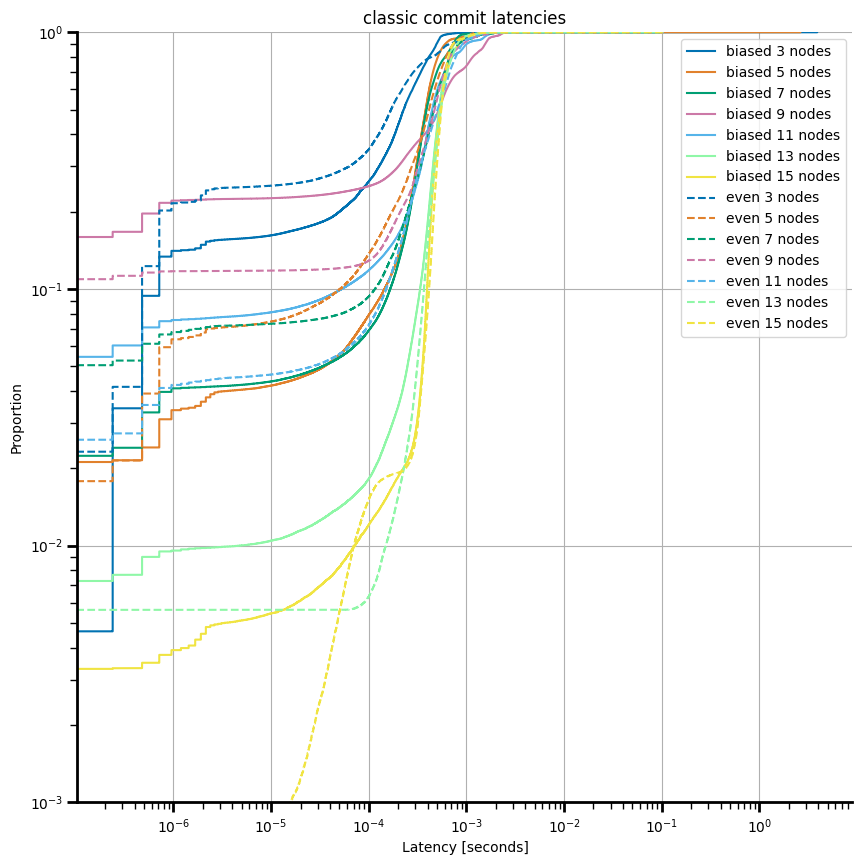

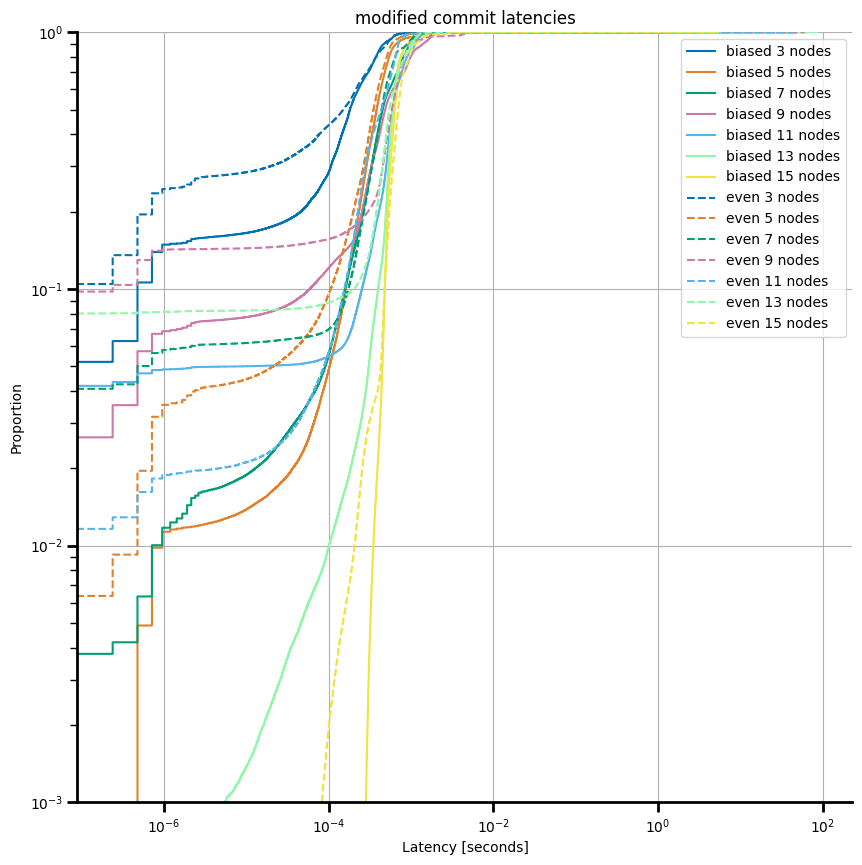

In [157]:
plot_commit_latencies(DATA, nodes=[], algos=["classic"], probs=None, size=(10,10))
plot_commit_latencies(DATA, nodes=[], algos=["modified"], probs=None, size=(10,10))


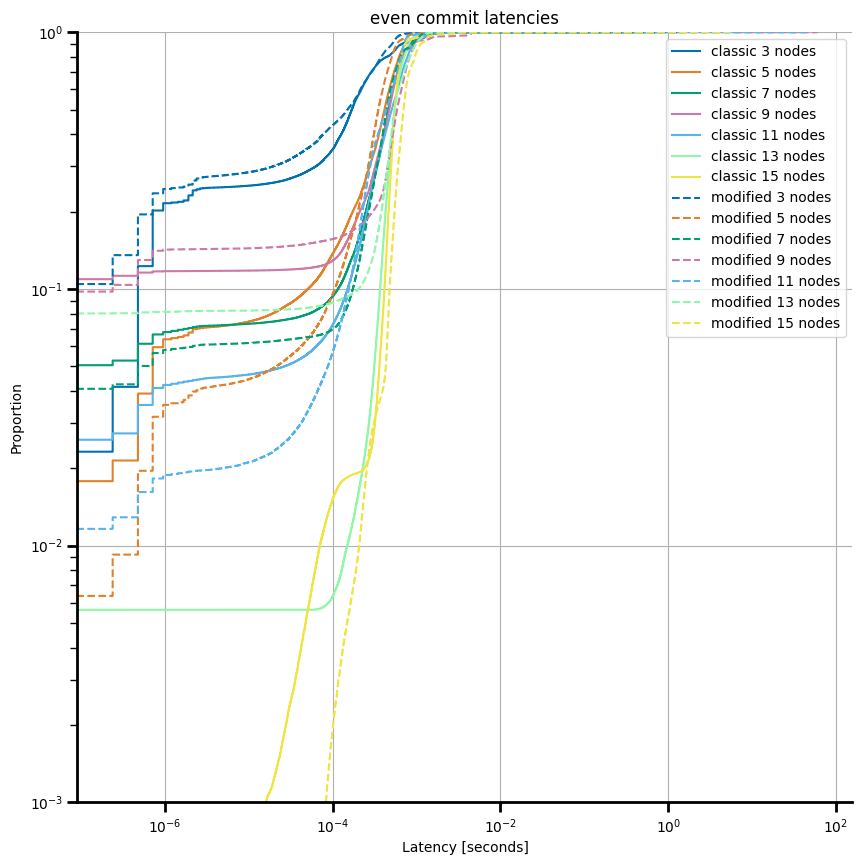

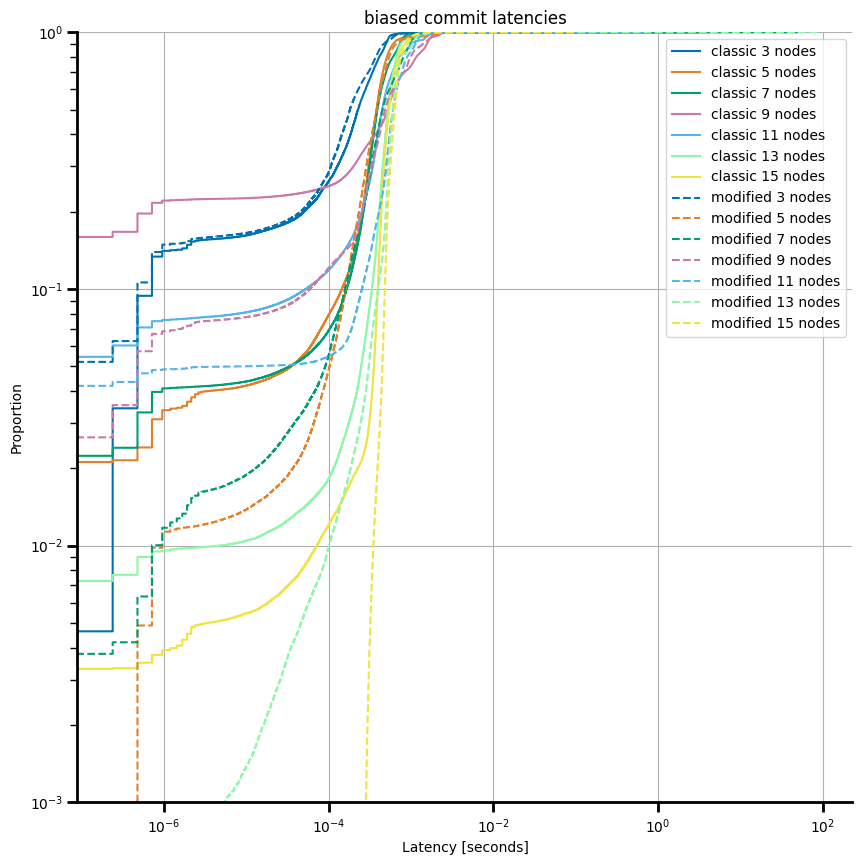

In [158]:
plot_commit_latencies(DATA, nodes=[], algos=None, probs=['even'], size=(10,10))
plot_commit_latencies(DATA, nodes=[], algos=None, probs=['biased'], size=(10,10))

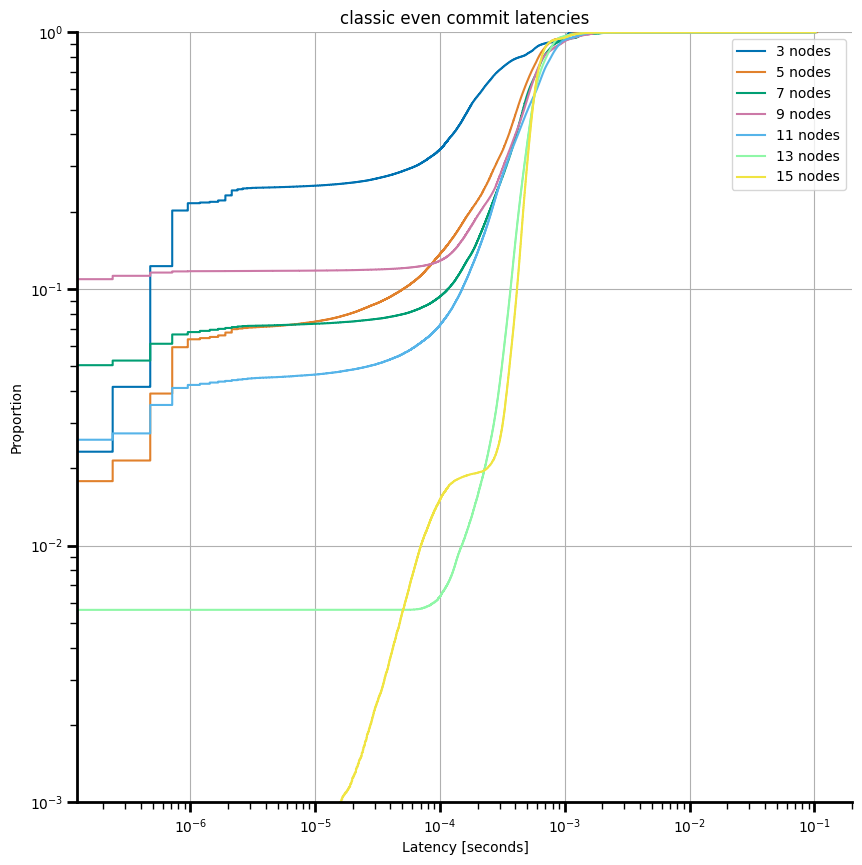

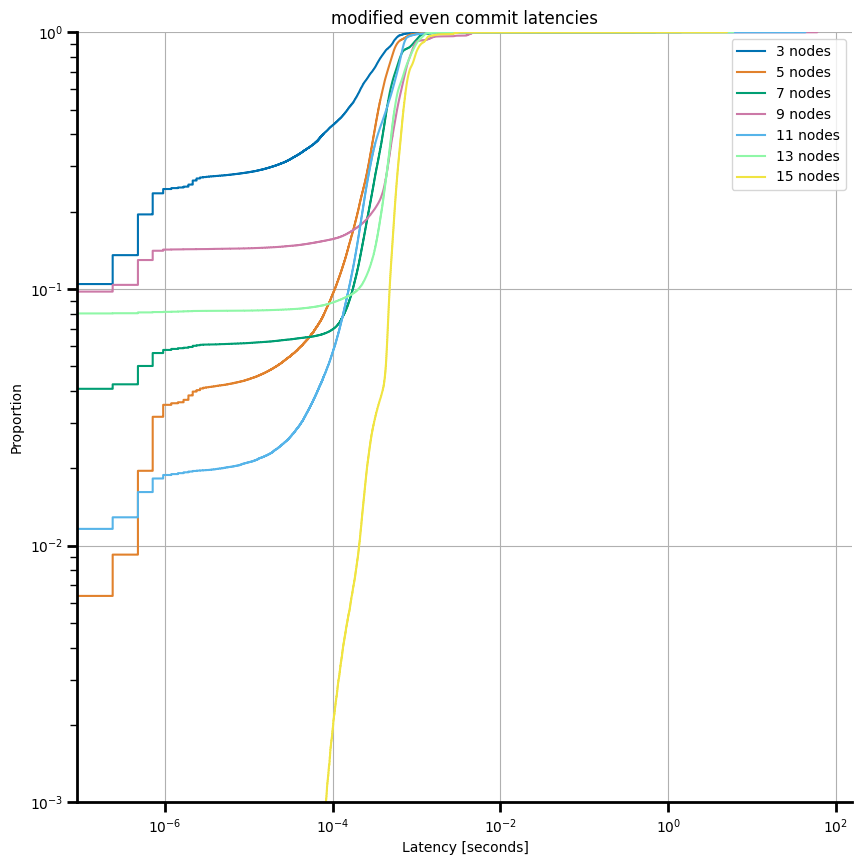

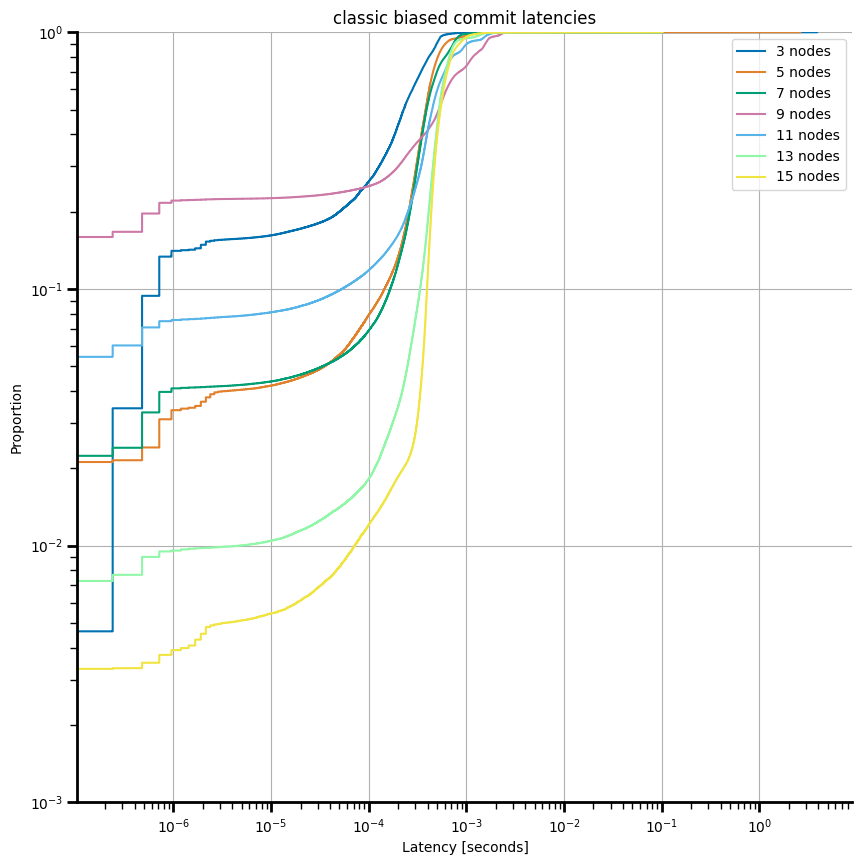

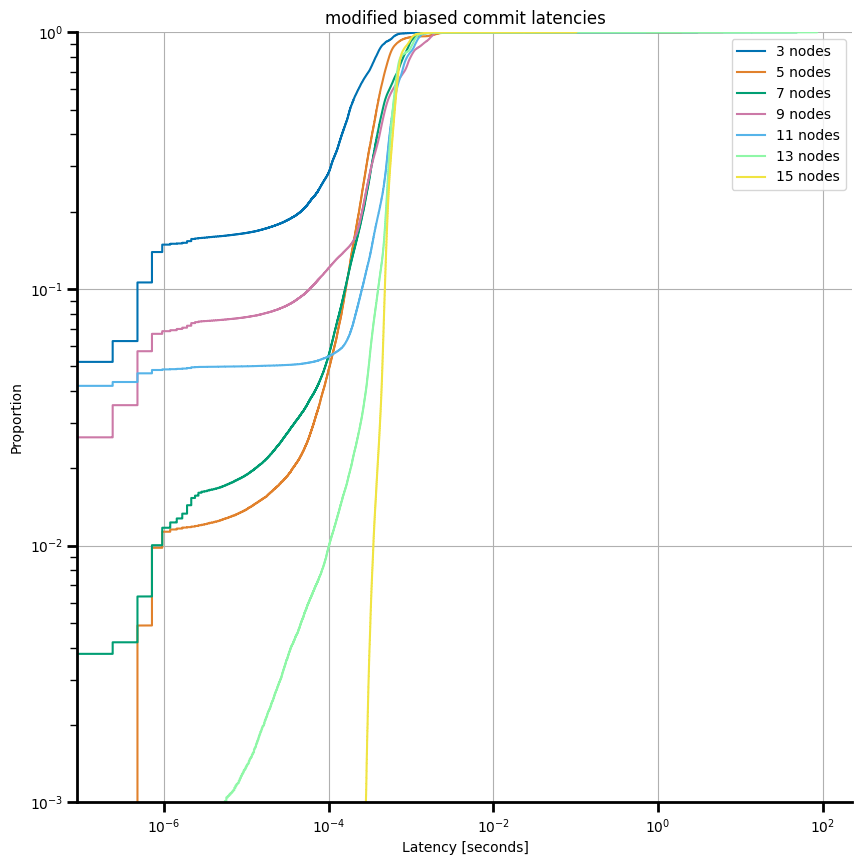

In [159]:
plot_commit_latencies(DATA, nodes=[], algos=["classic"], probs=['even'], size=(10,10))
plot_commit_latencies(DATA, nodes=[], algos=["modified"], probs=['even'], size=(10,10))
plot_commit_latencies(DATA, nodes=[], algos=["classic"], probs=['biased'], size=(10,10))
plot_commit_latencies(DATA, nodes=[], algos=["modified"], probs=['biased'], size=(10,10))

# Commit Rate Plots

classic: 140 <class 'list'>, modified: 140, <class 'list'>


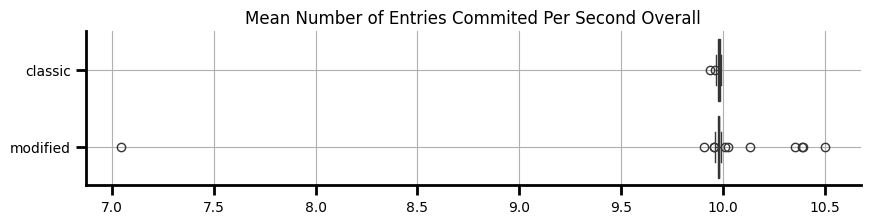

In [160]:
classic_col = get_col_from_all(DATA, "commitRate", algo="classic")
modified_col = get_col_from_all(DATA, "commitRate", algo="modified")

print(f"classic: {len(classic_col)} {type(classic_col)}, modified: {len(modified_col)}, {type(modified_col)}")

data = pd.DataFrame({"classic": classic_col, "modified": modified_col})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

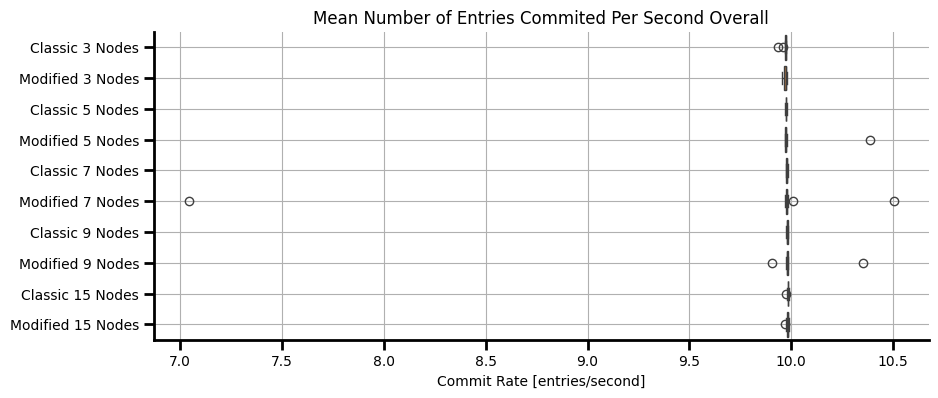

In [161]:
data = pd.DataFrame({
    "Classic 3 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=3),
    "Modified 3 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=3),
    "Classic 5 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=5),
    "Modified 5 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=5),
    "Classic 7 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=7),
    "Modified 7 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=7),
    "Classic 9 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=9),
    "Modified 9 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=9),
    "Classic 15 Nodes": get_col_from_all(DATA, "commitRate", algo="classic", nodes=15),
    "Modified 15 Nodes": get_col_from_all(DATA, "commitRate", algo="modified", nodes=15)
})

alternatic_palette = ['#3274A1', '#E1812C'] * 5

plt.figure(figsize=(10,4))
sns.boxplot(data, orient='h', palette=alternatic_palette)
plt.title("Mean Number of Entries Commited Per Second Overall")
plt.xlabel("Commit Rate [entries/second]")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

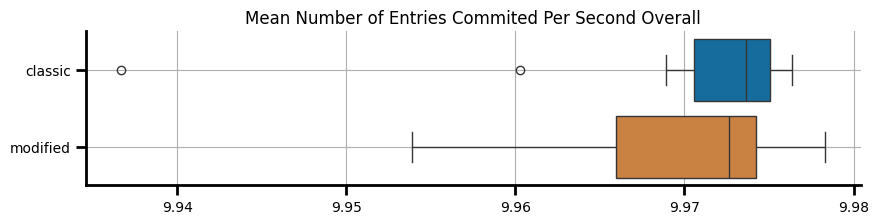

In [162]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=3)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=3)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

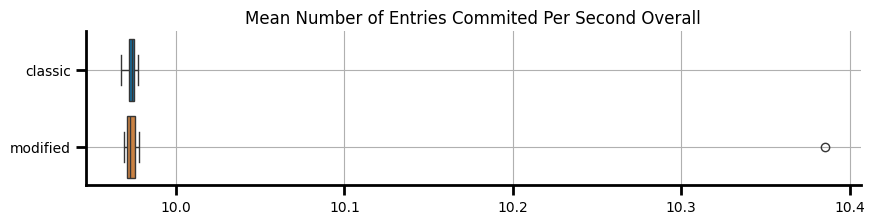

In [163]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=5)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=5)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

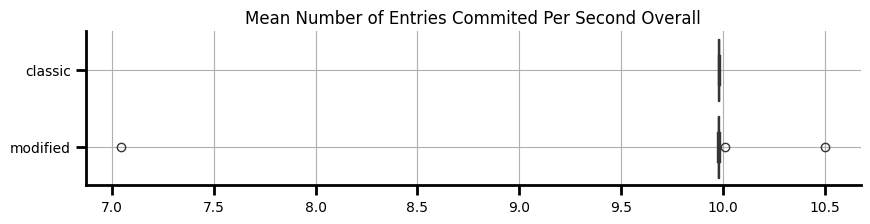

In [164]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=7)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=7)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

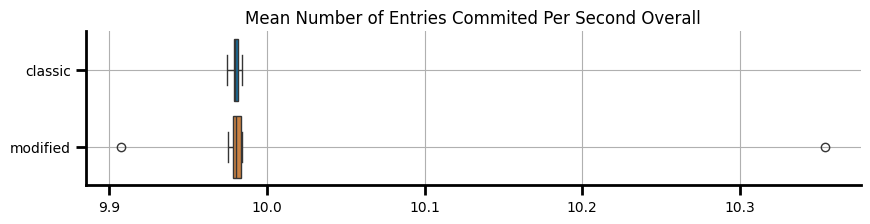

In [165]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=9)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=9)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

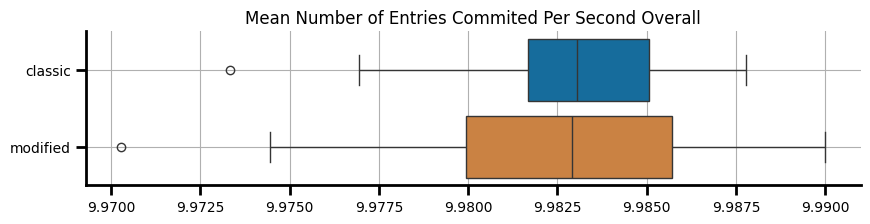

In [166]:
classic = get_col_from_all(DATA, "commitRate", algo="classic", nodes=15)
modified = get_col_from_all(DATA, "commitRate", algo="modified", nodes=15)

data = pd.DataFrame({"classic": classic, "modified": modified})

plt.figure(figsize=(10,2))
sns.boxplot(data, orient='h')
plt.title("Mean Number of Entries Commited Per Second Overall")

plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='both', which='major', width=2, length=7)
plt.show()

# Term Count Plots

In [167]:
def count_terms(file : str) -> tuple[int, int]:
    df = open_csv(file)
    terms_seen = df["term"].unique()
    num_productive_terms = len(terms_seen)
    num_empty_terms = terms_seen.max() - num_productive_terms
    return num_productive_terms, num_empty_terms


def get_terms(file : str) -> tuple[list[int], list[int]]:
    df = open_csv(file)
    terms_seen = df["term"].unique().tolist()
    terms_missed = [term for term in range(max(terms_seen)) if not term in terms_seen]
    return terms_seen, terms_missed

In [168]:
#TODO change this to actuall make plots for this not ECDFs 

def plot_term_counts(df : pd.DataFrame, term_type : str, algos = None, nodes = None, probs = None, size : tuple[int, int] = (10,5)):
    if algos is None or len(algos) == 0:
        algos = df["algorithm"].unique().tolist()
    if nodes is None or len(nodes) == 0:
        nodes = df["nodeCount"].unique().tolist()
    if probs is None or len(probs) == 0:
        probs = df["crashProbability"].unique().tolist()
    
    lines = len(algos) * len(nodes) * len(probs)
    palette = COLOR_PALETTE[ : (lines//2)]

    data_to_plot = {}

    sns.set_palette(sns.color_palette(palette))
    plt.figure(figsize=size)
    line_label_elements = []
    for idx_algo, algo in enumerate(algos):
        for idx_prob, crash_prob in enumerate(probs):
            for idx_node, node in enumerate(nodes):
                line_label_elements = []
                if len(algos) > 1:
                    line_label_elements.append(algo)
                if len(probs) > 1:
                    line_label_elements.append(crash_prob)
                if len(nodes) > 1:
                    line_label_elements.append(f"{node} nodes")
                
                line_label = " ".join(line_label_elements)

                files = df[(df["algorithm"] == algo) & (df["nodeCount"] == node) & (df["crashProbability"] == crash_prob)]["path"]
                term_counts = [count_terms(file)[0] if term_type == 'productive' else count_terms(file)[1] for file in files]
                data_to_plot[line_label] = term_counts
                # print(len(term_counts), type(term_counts))
                
                sns.boxplot(data_to_plot, orient='h')
    

    title_elements = []
    if len(algos) == 1:
        title_elements.append(algo)
    if len(probs) == 1:
        title_elements.append(crash_prob)
    if len(nodes) == 1:
        title_elements.append(f"{node} nodes")

    plt.title(f'{" ".join(title_elements)} {term_type} term counts')
    plt.xlabel(f"{term_type} Terms")

    data_max = max(sum(list(data_to_plot.values()), []))
    # plt.xlim(0, min(data_max + 25, 800))

    plt.grid(visible=True)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=7)
    ax.tick_params(axis='both', which='minor', width=1, length=5)
    plt.show()

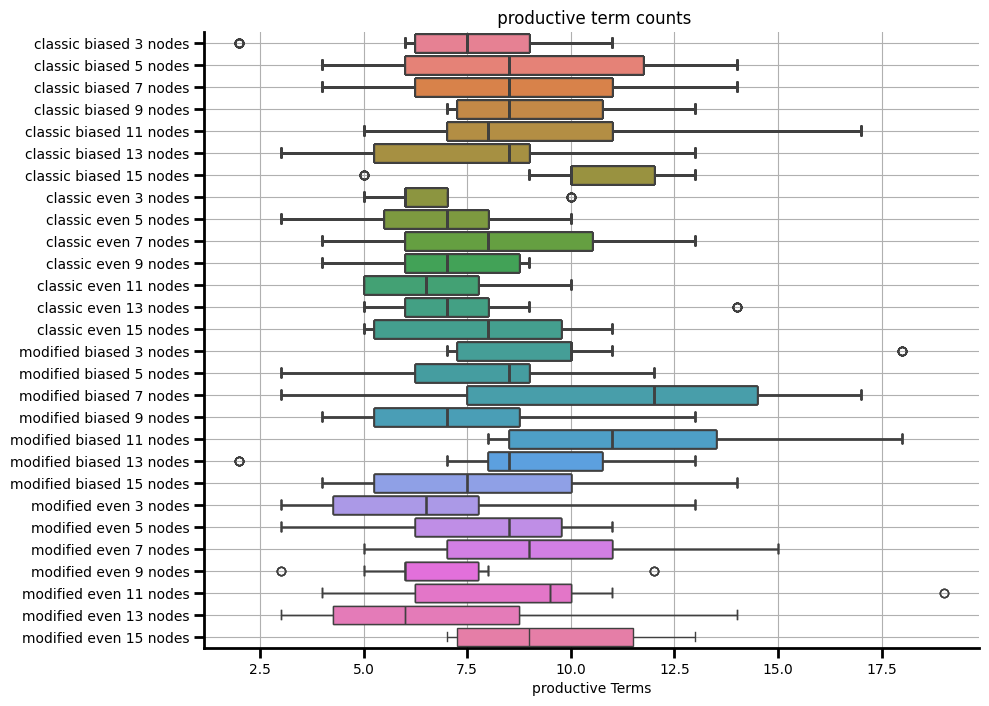

In [169]:
plot_term_counts(DATA, probs = [], algos = [], nodes = [], size=(10,8), term_type='productive') # All everything

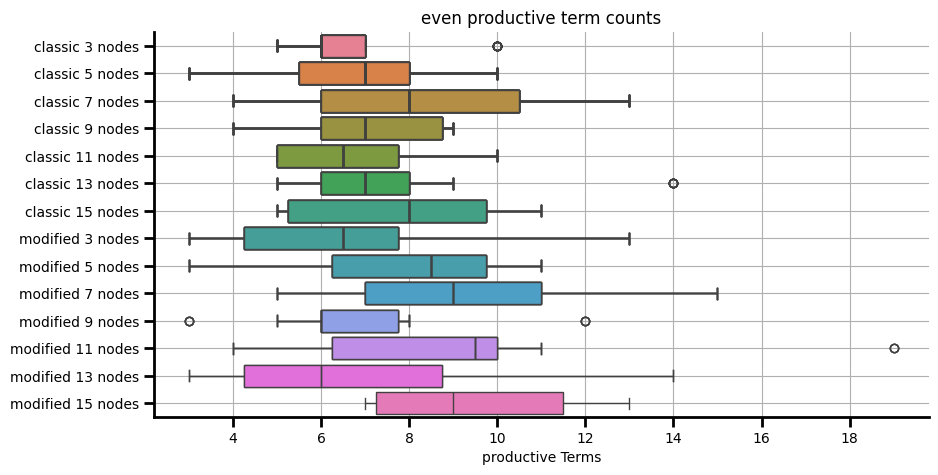

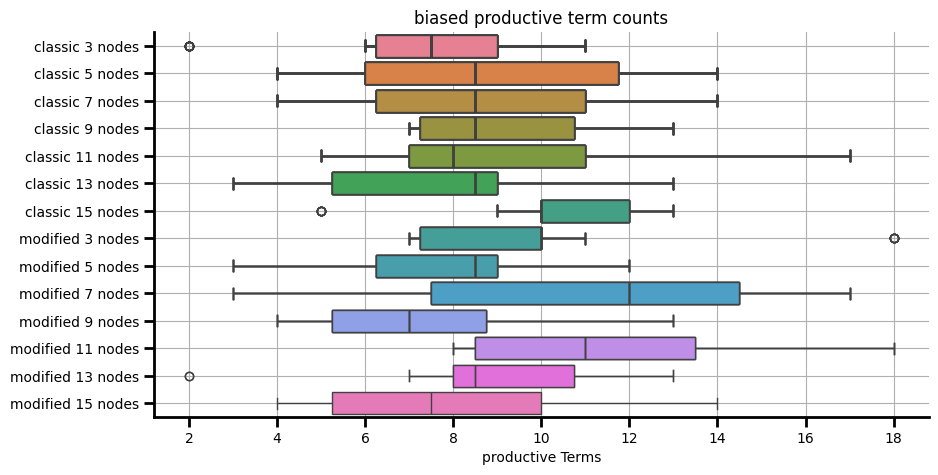

In [170]:
plot_term_counts(DATA, probs = ["even"], algos = [], nodes = [], term_type='productive')
plot_term_counts(DATA, probs = ["biased"], algos = [], nodes = [], term_type='productive')

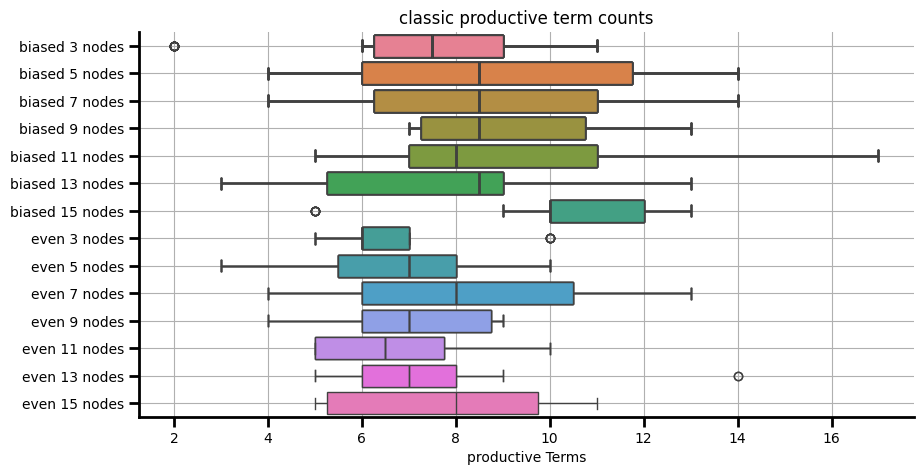

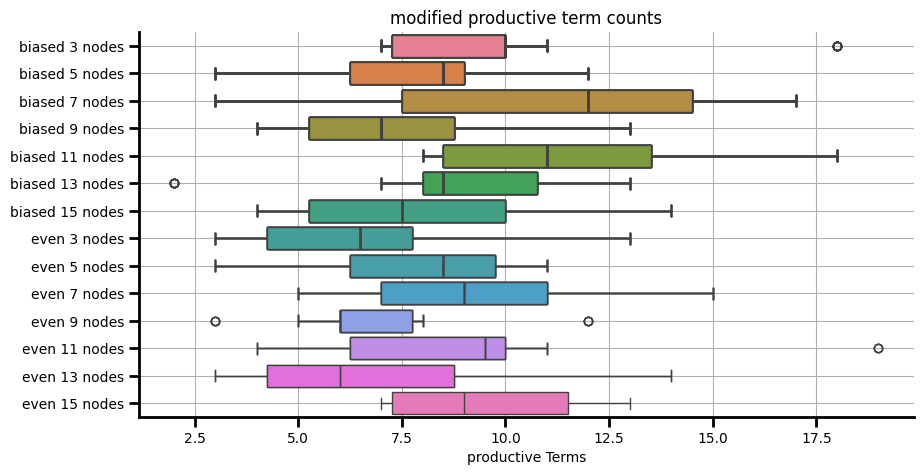

In [171]:
plot_term_counts(DATA, probs = [], algos = ["classic"], nodes = [], term_type='productive') 
plot_term_counts(DATA, probs = [], algos = ["modified"], nodes = [], term_type='productive') 

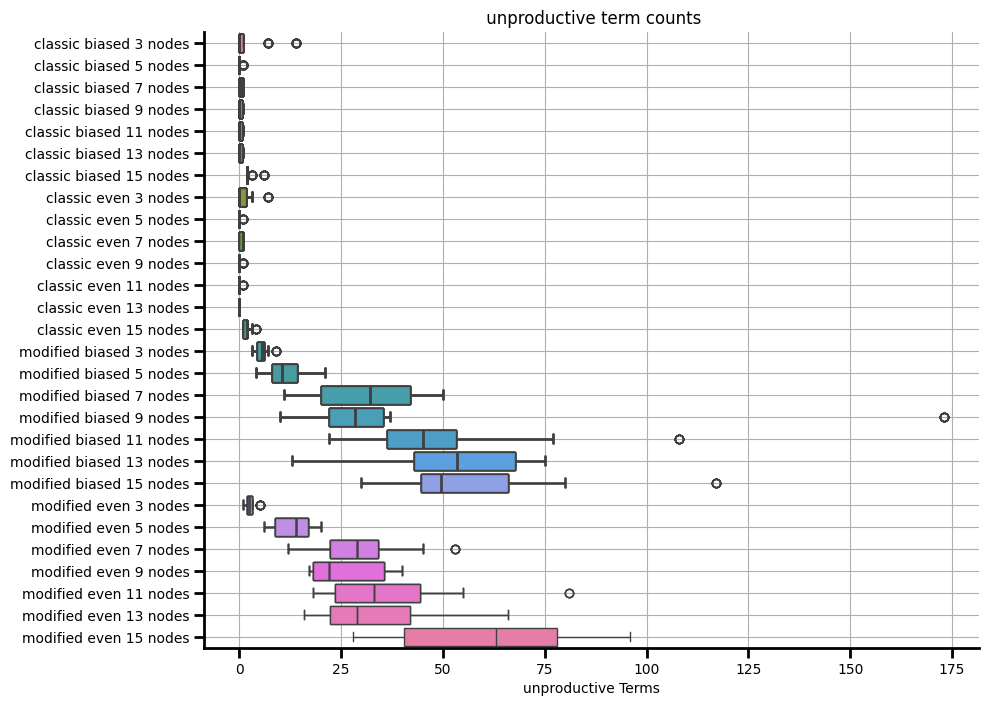

In [172]:
plot_term_counts(DATA, probs = [], algos = [], nodes = [], size=(10,8), term_type='unproductive') # All everything

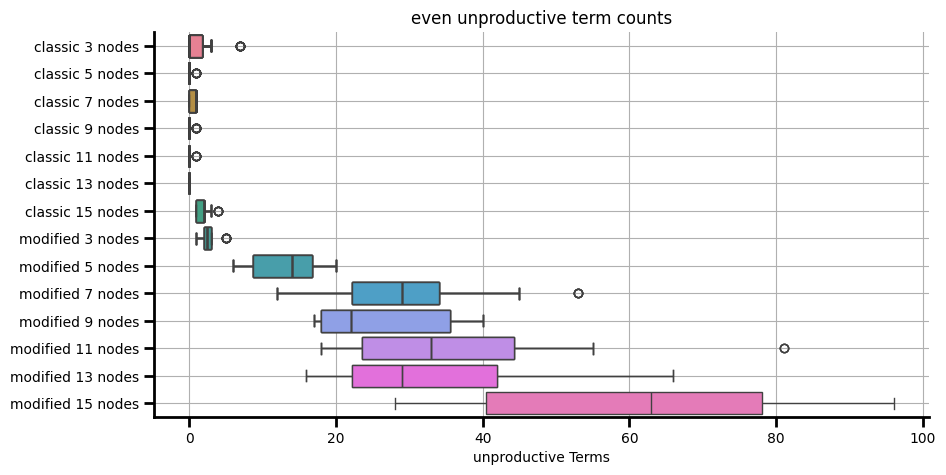

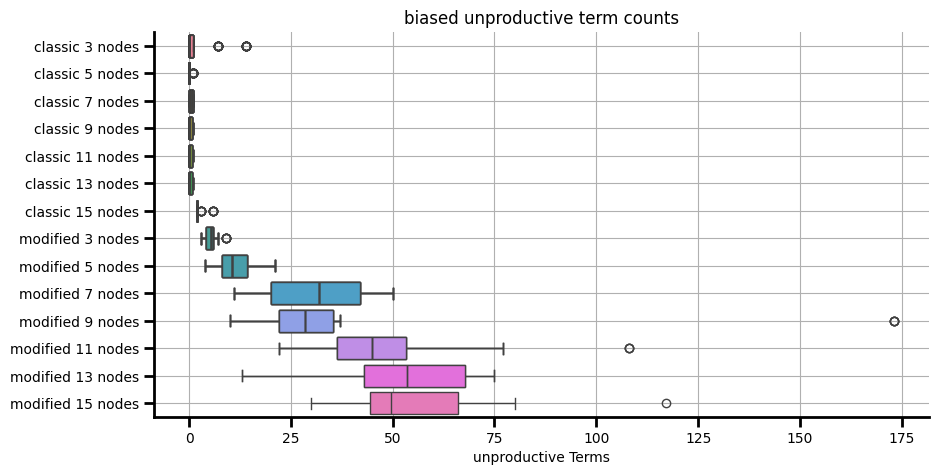

In [173]:
plot_term_counts(DATA, probs = ["even"], algos = [], nodes = [], term_type='unproductive')
plot_term_counts(DATA, probs = ["biased"], algos = [], nodes = [], term_type='unproductive')

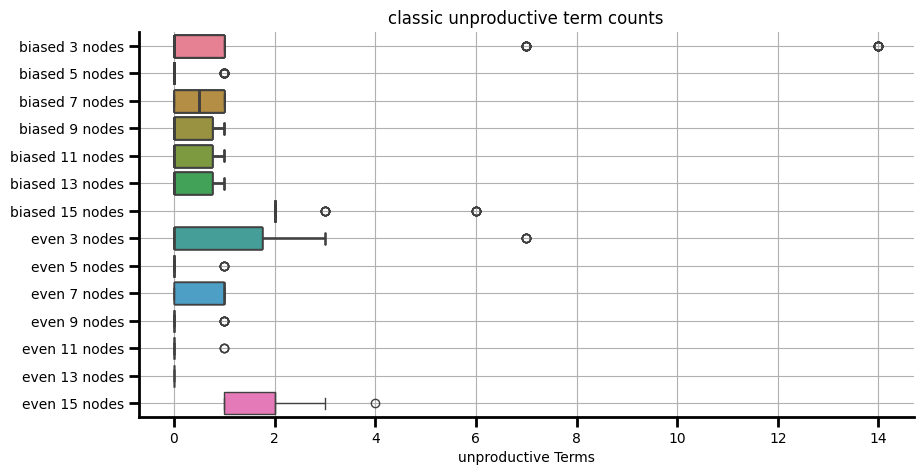

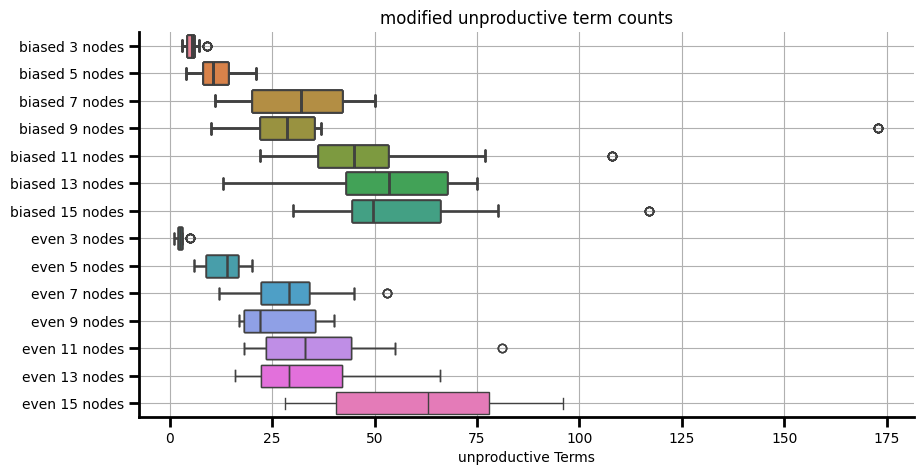

In [174]:
plot_term_counts(DATA, probs = [], algos = ["classic"], nodes = [], term_type='unproductive') 
plot_term_counts(DATA, probs = [], algos = ["modified"], nodes = [], term_type='unproductive') 

# Term Duration Plots

In [175]:
def get_term_durations(file : str) -> list[float]:
    df = open_csv(file)
    productive_terms, _ = get_terms(file)
    durations = []
    for term in productive_terms:
        try:
            term_entries = df[(df["term"] == term) & (df["leaderId"] == df["serverId"])]
            first_entry_time = term_entries.iloc[0]["storageTime"]
            last_entry_time = term_entries.iloc[-1]["storageTime"]
            term_duration = last_entry_time - first_entry_time
            if term_duration > 0.1:
                durations.append(term_duration)
        except:
            # print(f"Could not get term durations for term {term} in file {file}.")
            continue
    return durations

In [176]:
def plot_term_durations(df : pd.DataFrame, algos = None, nodes = None, probs = None, size : tuple[int, int] = (10,5)):
    if algos is None or len(algos) == 0:
        algos = df["algorithm"].unique().tolist()
    if nodes is None or len(nodes) == 0:
        nodes = df["nodeCount"].unique().tolist()
    if probs is None or len(probs) == 0:
        probs = df["crashProbability"].unique().tolist()
    
    lines = len(algos) * len(nodes) * len(probs)
    colors_needed = lines // 2 if len(algos) > 1 or len(probs) > 1 else lines
    palette = COLOR_PALETTE[ : colors_needed]
    
    data_to_plot = {}

    sns.set_palette(sns.color_palette(palette))
    plt.figure(figsize=size)
    line_label_elements = []
    for idx_algo, algo in enumerate(algos):
        for idx_prob, crash_prob in enumerate(probs):
            for idx_node, node in enumerate(nodes):
                line_label_elements = []
                if len(algos) > 1:
                    line_label_elements.append(algo)
                if len(probs) > 1:
                    line_label_elements.append(crash_prob)
                if len(nodes) > 1:
                    line_label_elements.append(f"{node} nodes")
                
                line_label = " ".join(line_label_elements)

                files = df[(df["algorithm"] == algo) & (df["nodeCount"] == node) & (df["crashProbability"] == crash_prob)]["path"]
                term_counts = [get_term_durations(file) for file in files]
                data = sum(term_counts, [])
                data_to_plot[line_label] = data
                
                sns.ecdfplot(data, label=line_label)

                dashed = False
                if (len(algos) > 1 and algo == 'modified'):
                    dashed = True
                elif (len(probs) > 1 and crash_prob == 'even'):
                    dashed = True
                if dashed:
                    [line.set_linestyle("--") for line in plt.gca().lines if line.get_label() == line_label]
    

    title_elements = []
    if len(algos) == 1:
        title_elements.append(algo)
    if len(probs) == 1:
        title_elements.append(crash_prob)
    if len(nodes) == 1:
        title_elements.append(f"{node} nodes")

    plt.title(f'{" ".join(title_elements)} term durations')
    plt.xlabel("Term Duration [seconds]")

    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(10**-2,1)
    # plt.xticks([10**exp for exp in range(1, 3)])
    

    plt.grid(visible=True)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=7)
    ax.tick_params(axis='both', which='minor', width=1, length=5)
    plt.legend()
    plt.show()

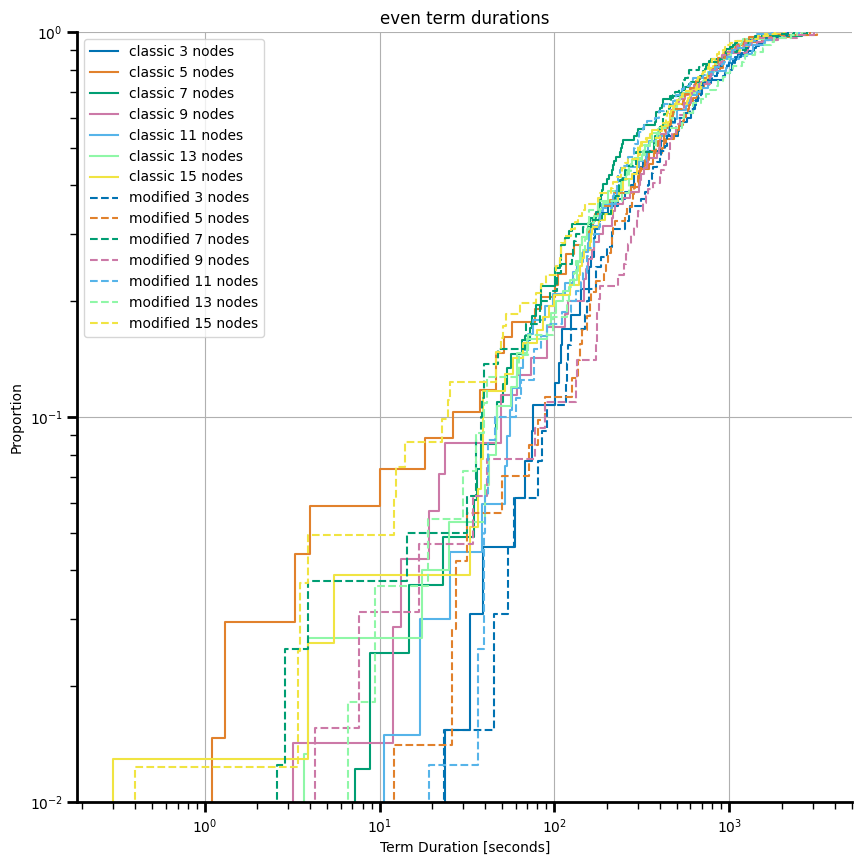

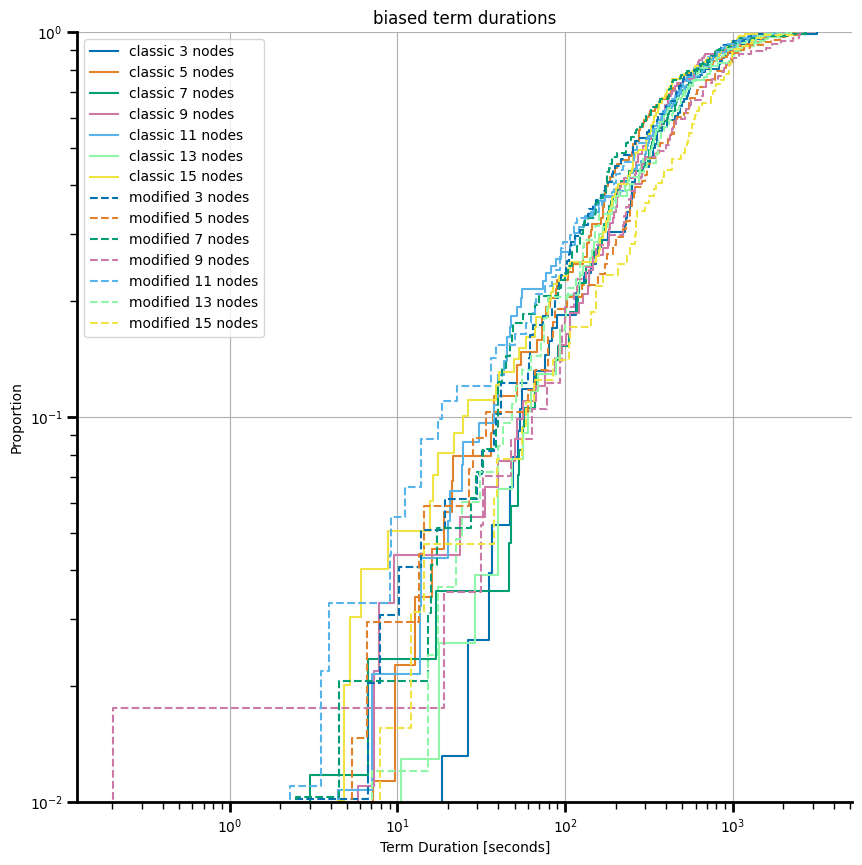

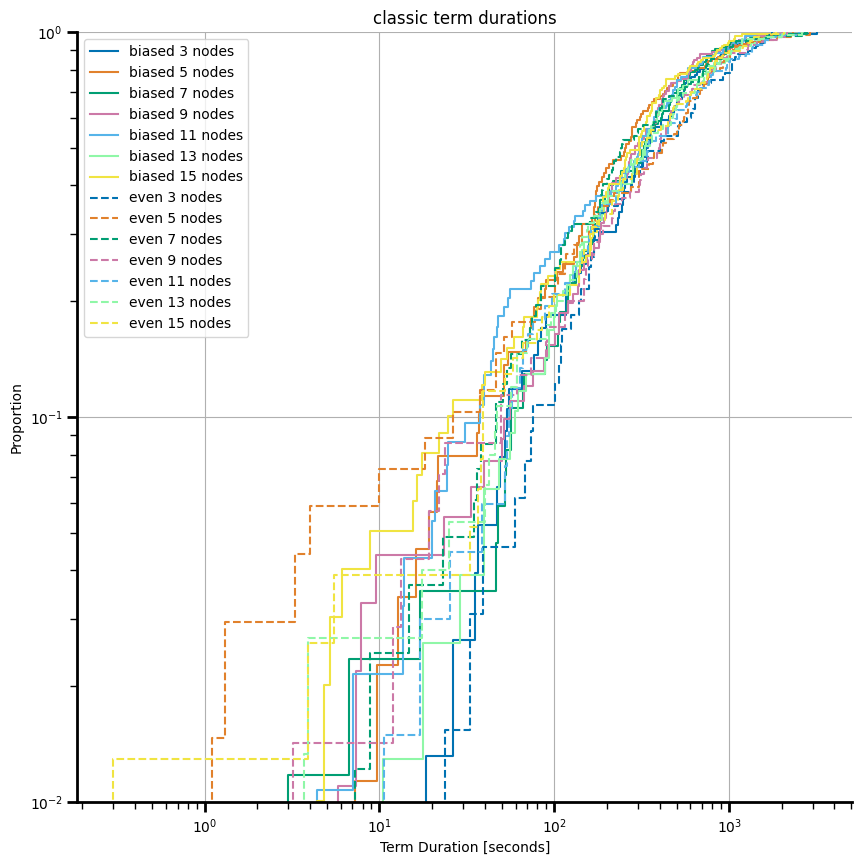

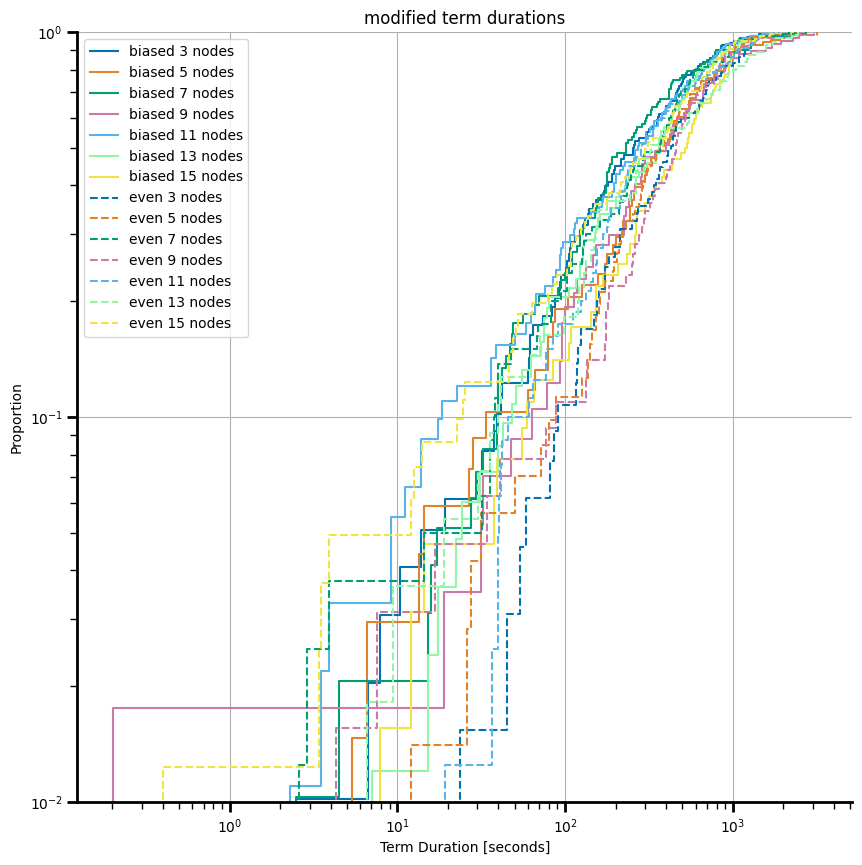

In [193]:
plot_term_durations(DATA, probs = ["even"], algos = [], nodes = [], size=(10,10))

plot_term_durations(DATA, probs = ["biased"], algos = [], nodes = [], size=(10,10))

plot_term_durations(DATA, probs = [], algos = ["classic"], nodes = [], size=(10,10))

plot_term_durations(DATA, probs = [], algos = ["modified"], nodes = [], size=(10,10))

# Election Duration Plots

In [178]:
def get_election_durations(file : str) -> list[float]:
    df = open_csv(file)
    productive_terms, _ = get_terms(file)
    durations = []
    for term_idx, term in enumerate(productive_terms[:-1]):
        try:
            term_entries = df[(df["term"] == term) & (df["leaderId"] == df["serverId"])]
            next_term_entries = df[(df["term"] == productive_terms[term_idx + 1]) & (df["leaderId"] == df["serverId"])]
            first_term_end = term_entries.iloc[-1]["storageTime"]
            next_term_start = next_term_entries.iloc[0]["storageTime"]


            term_duration = next_term_start - first_term_end
            if term_duration > 0.0:
                durations.append(term_duration)
            if term_duration > 5:
                print(f"Run {file} has election {term_duration} s > 5 s.")
        except Exception as e:
            continue

    return durations

In [179]:
for file in tqdm(DATA["path"]):
    get_election_durations(file)

  2%|▎         | 7/280 [00:00<00:24, 11.00it/s]

Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\classic\3_nodes\60_minutes\run_4912914\data_run_4912914.csv has election 7.503997325897217 s > 5 s.
Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\classic\3_nodes\60_minutes\run_4912915\data_run_4912915.csv has election 5.0855090618133545 s > 5 s.


 29%|██▊       | 80/280 [00:17<00:22,  8.84it/s]

Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\modified\3_nodes\60_minutes\run_4912928\data_run_4912928.csv has election 7.574419021606445 s > 5 s.


 38%|███▊      | 107/280 [00:21<00:34,  4.98it/s]

Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\modified\9_nodes\60_minutes\run_4915886\data_run_4915886.csv has election 5.978654146194458 s > 5 s.
Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\modified\9_nodes\60_minutes\run_4915886\data_run_4915886.csv has election 6.982032060623169 s > 5 s.


100%|██████████| 280/280 [01:05<00:00,  4.27it/s]


In [180]:
def plot_election_durations(df : pd.DataFrame, algos = None, nodes = None, probs = None, size : tuple[int, int] = (10,5)):
    if algos is None or len(algos) == 0:
        algos = df["algorithm"].unique().tolist()
    if nodes is None or len(nodes) == 0:
        nodes = df["nodeCount"].unique().tolist()
    if probs is None or len(probs) == 0:
        probs = df["crashProbability"].unique().tolist()
    
    lines = len(algos) * len(nodes) * len(probs)
    colors_needed = lines // 2 if len(algos) > 1 or len(probs) > 1 else lines
    palette = COLOR_PALETTE[ : colors_needed]
    
    data_to_plot = {}

    sns.set_palette(sns.color_palette(palette))
    plt.figure(figsize=size)
    line_label_elements = []
    for idx_algo, algo in enumerate(algos):
        for idx_prob, crash_prob in enumerate(probs):
            for idx_node, node in enumerate(nodes):
                line_label_elements = []
                if len(algos) > 1:
                    line_label_elements.append(algo)
                if len(probs) > 1:
                    line_label_elements.append(crash_prob)
                if len(nodes) > 1:
                    line_label_elements.append(f"{node} nodes")
                
                line_label = " ".join(line_label_elements)

                files = df[(df["algorithm"] == algo) & (df["nodeCount"] == node) & (df["crashProbability"] == crash_prob)]["path"]
                term_counts = [get_election_durations(file) for file in files]
                data = sum(term_counts, [])
                data_to_plot[line_label] = data
                
                sns.ecdfplot(data, label=line_label)

                dashed = False
                if (len(algos) > 1 and algo == 'modified'):
                    dashed = True
                elif (len(probs) > 1 and crash_prob == 'even'):
                    dashed = True
                if dashed:
                    [line.set_linestyle("--") for line in plt.gca().lines if line.get_label() == line_label]
    

    title_elements = []
    if len(algos) == 1:
        title_elements.append(algo)
    if len(probs) == 1:
        title_elements.append(crash_prob)
    if len(nodes) == 1:
        title_elements.append(f"{node} nodes")

    plt.title(f'{" ".join(title_elements)} election durations')
    plt.xlabel("Election Duration [seconds]")

    plt.yscale('log')
    plt.xscale('log')
    # plt.ylim(10**-2,1)
    # plt.xlim(0.2, 1000)
    # plt.xticks([10**exp for exp in range(1, 3)])
    

    plt.grid(visible=True)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=7)
    ax.tick_params(axis='both', which='minor', width=1, length=5)
    plt.legend()
    plt.show()

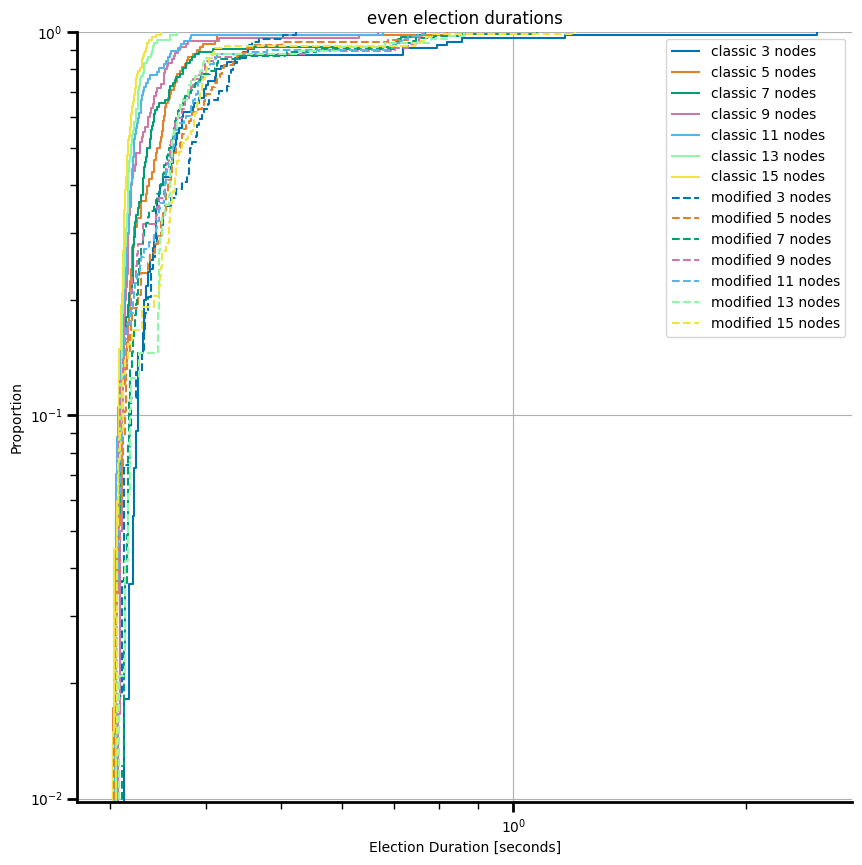

In [192]:
plot_election_durations(DATA, probs = ["even"], algos = [], nodes = [], size = (10,10))


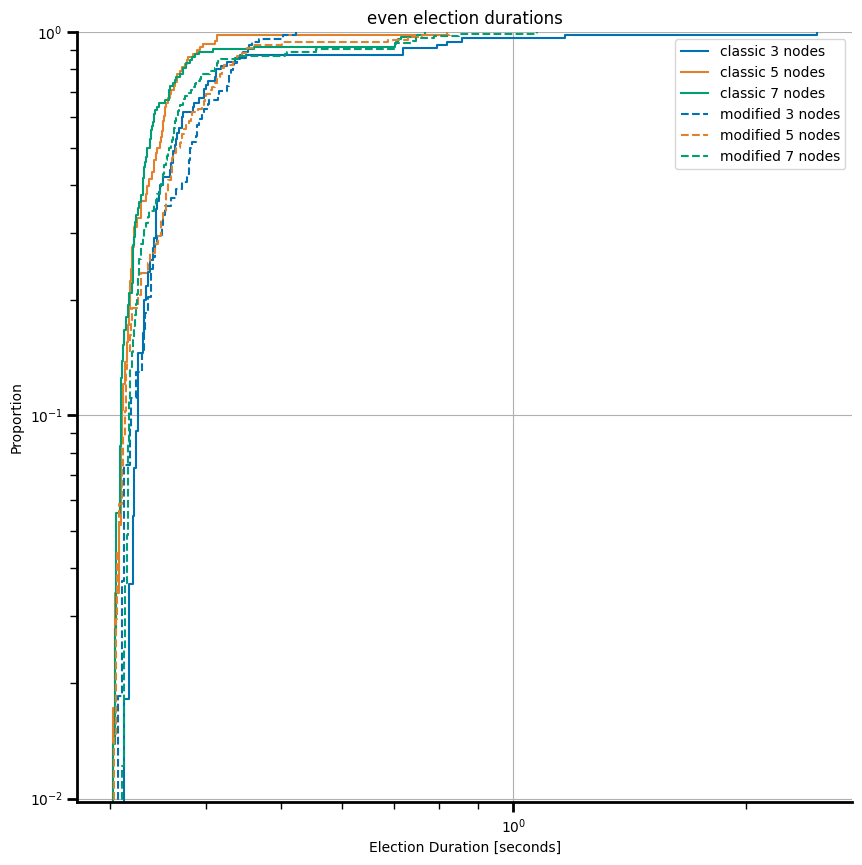

In [191]:
plot_election_durations(DATA, probs = ["even"], algos = [], nodes = [3,5,7], size = (10,10))

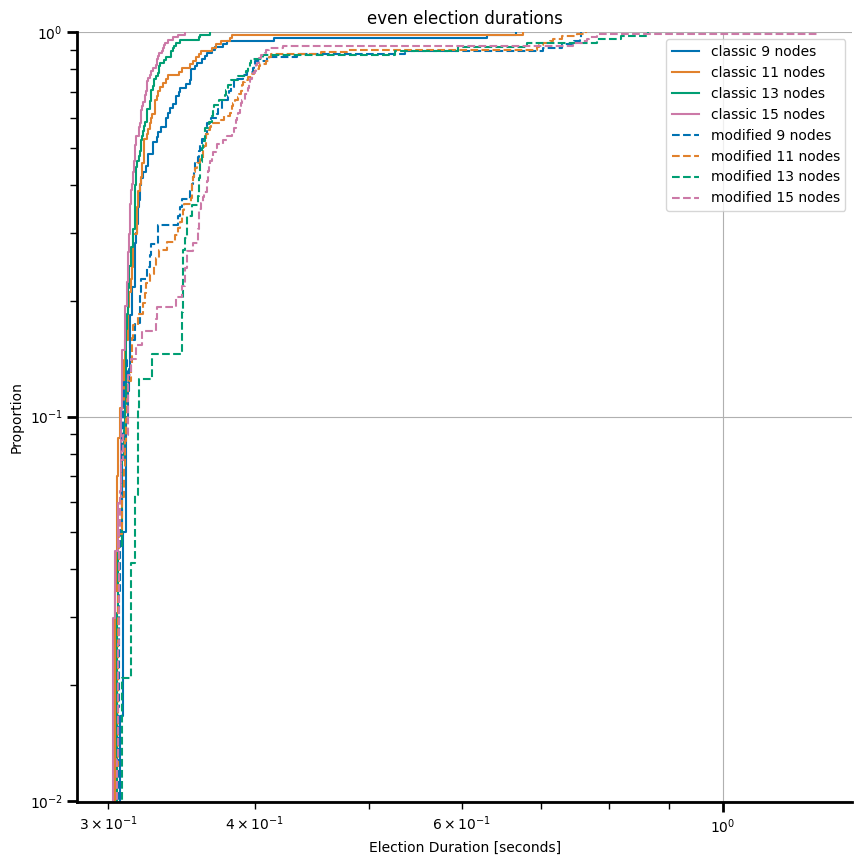

In [182]:
plot_election_durations(DATA, probs = ["even"], algos = [], nodes = [9,11,13,15], size = (10,10))

Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\classic\3_nodes\60_minutes\run_4912914\data_run_4912914.csv has election 7.503997325897217 s > 5 s.
Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\classic\3_nodes\60_minutes\run_4912915\data_run_4912915.csv has election 5.0855090618133545 s > 5 s.
Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\modified\3_nodes\60_minutes\run_4912928\data_run_4912928.csv has election 7.574419021606445 s > 5 s.


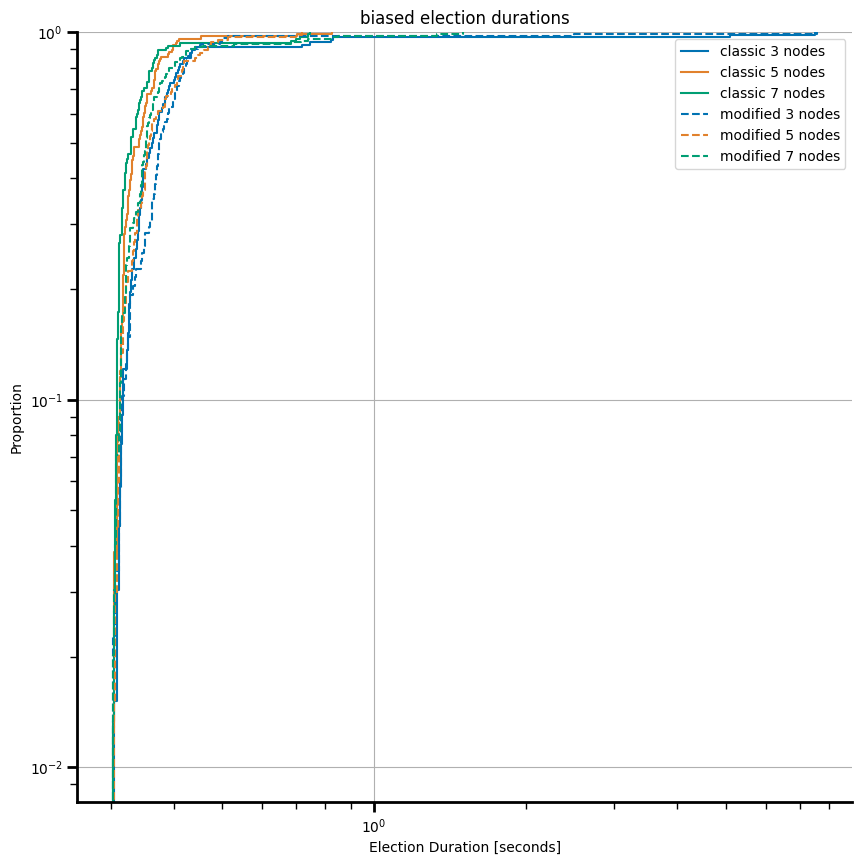

In [183]:
plot_election_durations(DATA, probs = ["biased"], algos = [], nodes = [3,5,7], size = (10,10))

Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\modified\9_nodes\60_minutes\run_4915886\data_run_4915886.csv has election 5.978654146194458 s > 5 s.
Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\modified\9_nodes\60_minutes\run_4915886\data_run_4915886.csv has election 6.982032060623169 s > 5 s.


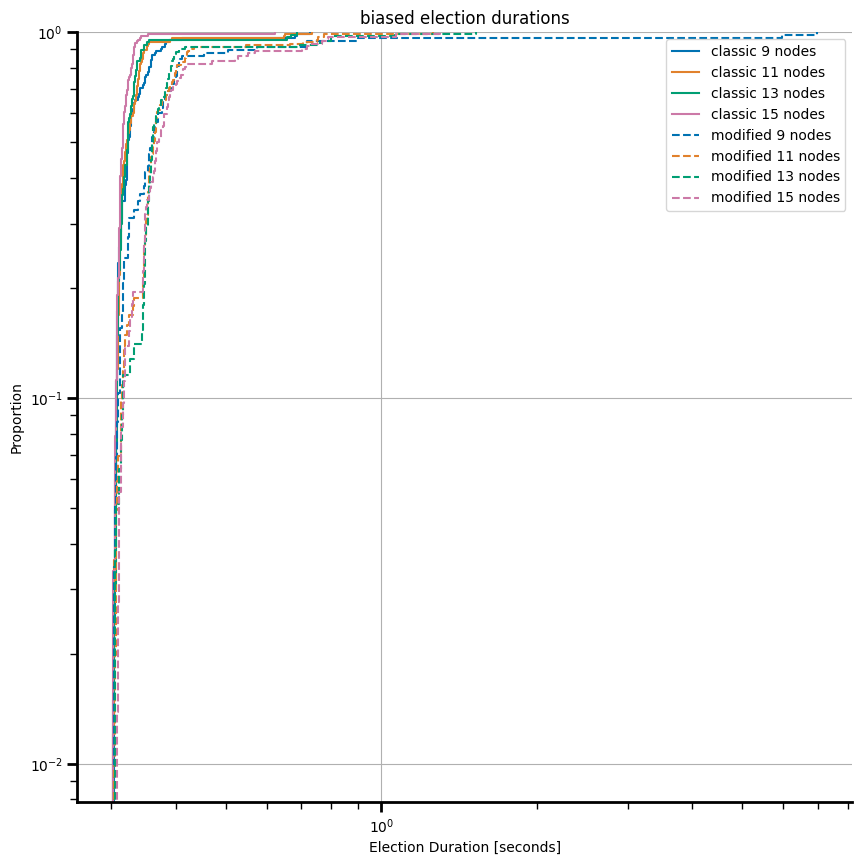

In [184]:
plot_election_durations(DATA, probs = ["biased"], algos = [], nodes = [9,11,13,15], size = (10,10))

# Uptime Plots

In [185]:
def plot_uptime(df : pd.DataFrame, algos = None, nodes = None, probs = None, size : tuple[int, int] = (10,5)):
    if algos is None or len(algos) == 0:
        algos = df["algorithm"].unique().tolist()
    if nodes is None or len(nodes) == 0:
        nodes = df["nodeCount"].unique().tolist()
    if probs is None or len(probs) == 0:
        probs = df["crashProbability"].unique().tolist()
    
    lines = len(algos) * len(nodes) * len(probs)
    palette = COLOR_PALETTE[ : (lines//2)]

    data_to_plot = {}

    sns.set_palette(sns.color_palette(palette))
    plt.figure(figsize=size)
    line_label_elements = []
    for idx_algo, algo in enumerate(algos):
        for idx_prob, crash_prob in enumerate(probs):
            for idx_node, node in enumerate(nodes):
                line_label_elements = []
                if len(algos) > 1:
                    line_label_elements.append(algo)
                if len(probs) > 1:
                    line_label_elements.append(crash_prob)
                if len(nodes) > 1:
                    line_label_elements.append(f"{node} nodes")
                
                line_label = " ".join(line_label_elements)

                files = df[(df["algorithm"] == algo) & (df["nodeCount"] == node) & (df["crashProbability"] == crash_prob)]["path"]
                data = [3600 - sum(get_election_durations(file)) for file in files]
                data_to_plot[line_label] = data
                
    
    sns.boxplot(data_to_plot, orient='h')
    

    title_elements = []
    if len(algos) == 1:
        title_elements.append(algo)
    if len(probs) == 1:
        title_elements.append(crash_prob)
    if len(nodes) == 1:
        title_elements.append(f"{node} nodes")

    plt.title(f'{" ".join(title_elements)} uptime')
    plt.xlabel("Uptime [seconds]")

    plt.grid(visible=True)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', width=2, length=7)
    ax.tick_params(axis='both', which='minor', width=1, length=5)
    plt.show()

Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\classic\3_nodes\60_minutes\run_4912914\data_run_4912914.csv has election 7.503997325897217 s > 5 s.
Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\classic\3_nodes\60_minutes\run_4912915\data_run_4912915.csv has election 5.0855090618133545 s > 5 s.


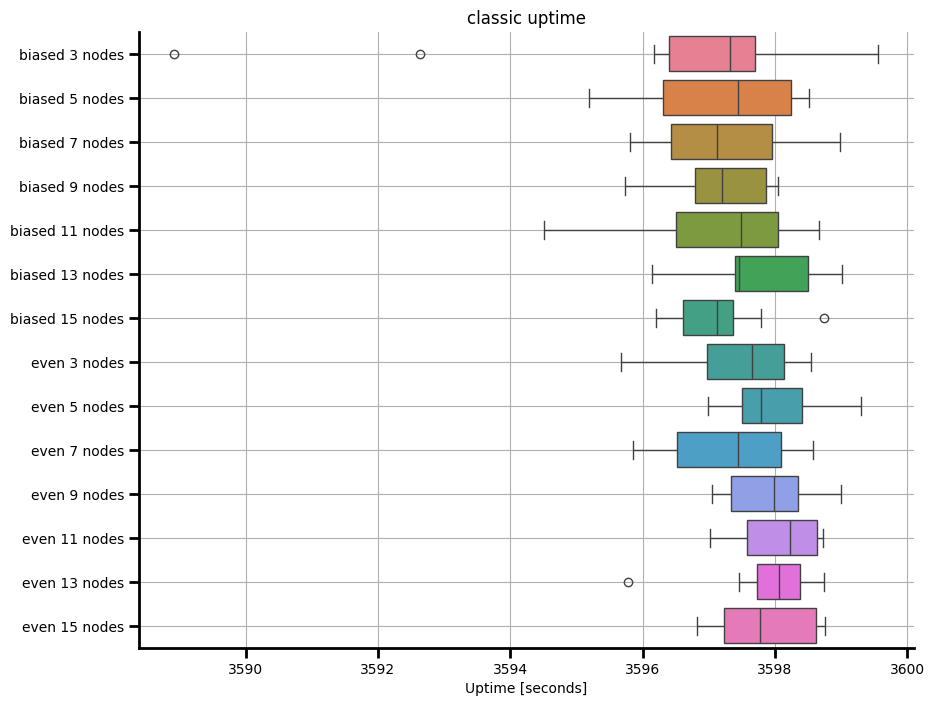

In [186]:
plot_uptime(DATA, size=(10,8), algos=["classic"], probs=[], nodes=[])

Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\modified\3_nodes\60_minutes\run_4912928\data_run_4912928.csv has election 7.574419021606445 s > 5 s.
Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\modified\9_nodes\60_minutes\run_4915886\data_run_4915886.csv has election 5.978654146194458 s > 5 s.
Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\modified\9_nodes\60_minutes\run_4915886\data_run_4915886.csv has election 6.982032060623169 s > 5 s.


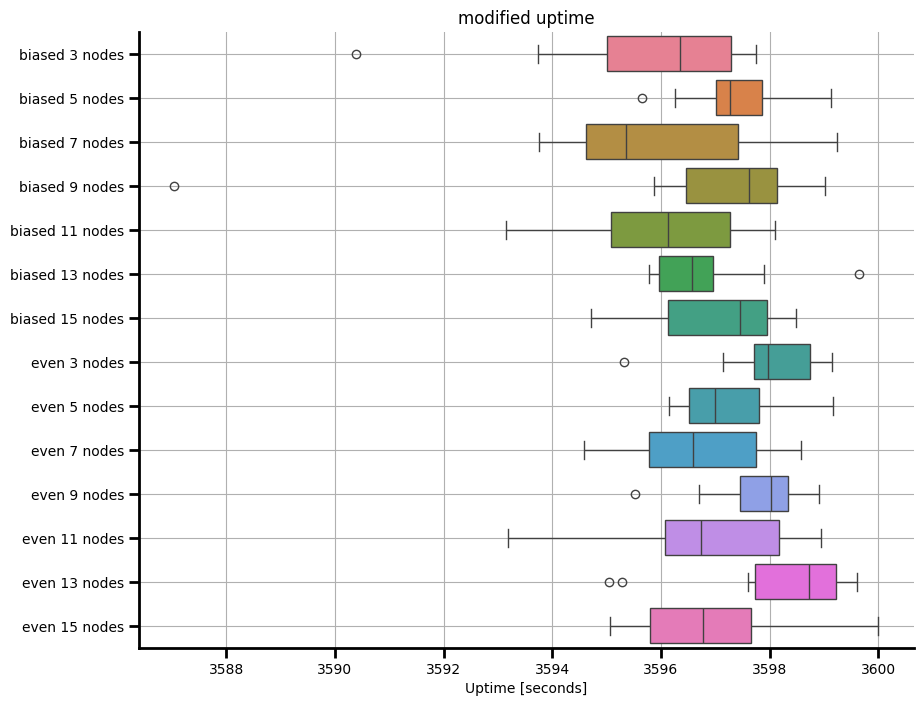

In [187]:
plot_uptime(DATA, size=(10,8), algos=["modified"], probs=[], nodes=[])

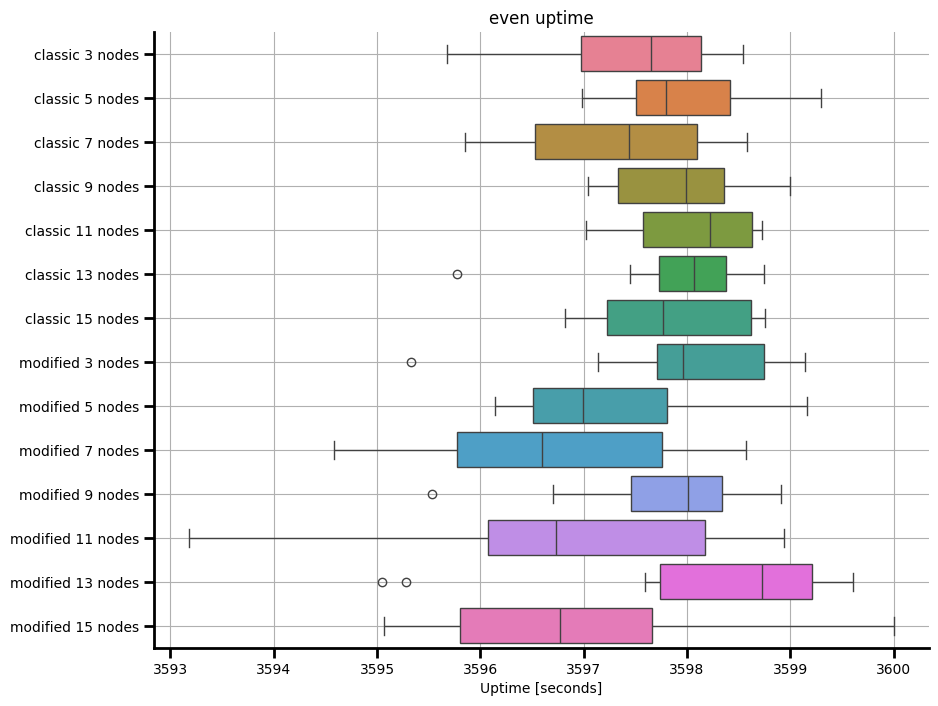

In [188]:
plot_uptime(DATA, size=(10,8), algos=[], probs=["even"], nodes=[])

Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\classic\3_nodes\60_minutes\run_4912914\data_run_4912914.csv has election 7.503997325897217 s > 5 s.
Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\classic\3_nodes\60_minutes\run_4912915\data_run_4912915.csv has election 5.0855090618133545 s > 5 s.
Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\modified\3_nodes\60_minutes\run_4912928\data_run_4912928.csv has election 7.574419021606445 s > 5 s.
Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\modified\9_nodes\60_minutes\run_4915886\data_run_4915886.csv has election 5.978654146194458 s > 5 s.
Run c:\Users\cursa\Documents\University\MSc CS\Thesis\MSc_Thesis_Raft\data_analysis\bench_data\biased\modified\9_nodes\60_minutes\run_4915886\data_run_4915886.csv has election 6.98203206062

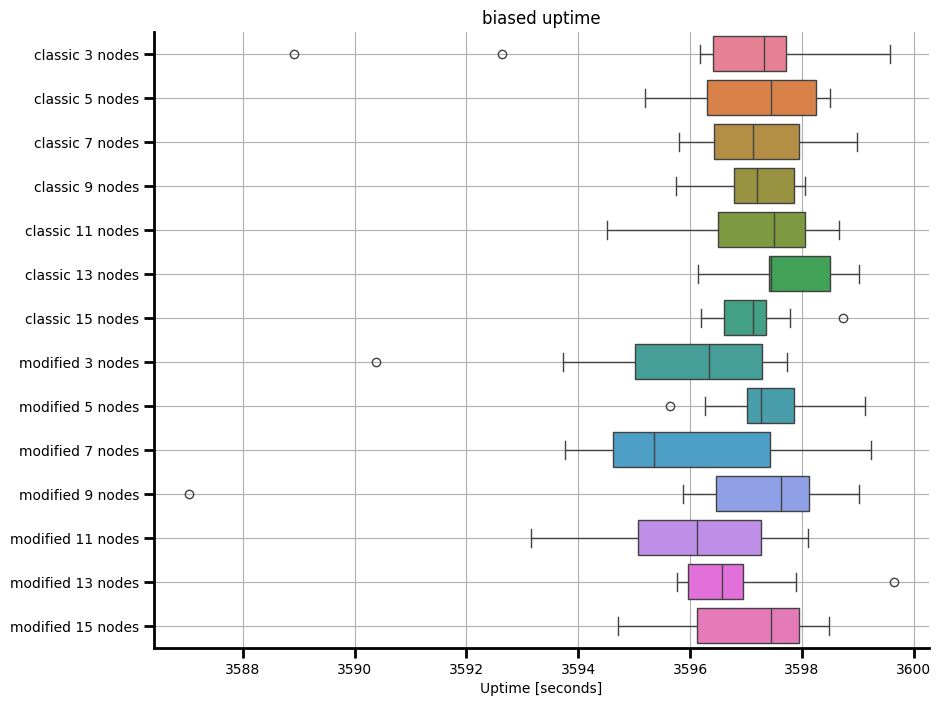

In [189]:
plot_uptime(DATA, size=(10,8), algos=[], probs=["biased"], nodes=[])